# Classifier d'articles de presse par CNN

## Données
- Articles de presse, à retrouver sur ce site https://archive.ics.uci.edu/ml/datasets/News+Aggregator (à ranger dans un dossier ./dataset/)
- word2vec entrainé, disponible à l'adresse : https://github.com/mmihaltz/word2vec-GoogleNews-vectors (à ranger en racine)


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import gensim
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
import codecs
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


stop_words = set(stopwords.words('english'))
# Any results you write to the current directory are saved as output.

In [5]:
EMBEDDING_DIM = 300 # how big is each word vector
MAX_SEQUENCE_LENGTH = 16 # max number of words in a comment to use
N_CLASS= 4

In [6]:
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [7]:
#http://archive.ics.uci.edu/ml/datasets/News+Aggregator
data= pd.read_csv("dataset/uci-news-aggregator.csv")
data=shuffle(data)
data['TITLE']=data['TITLE'].astype('str')

# Standardisation
data["tokens"] = data["TITLE"].str.replace(r"http\S+", "")
data["tokens"] = data["tokens"].str.replace(r"@\S+", "")
data["tokens"] = data["tokens"].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
data["tokens"] = data["tokens"].str.replace(r"@", "at")
data["tokens"] = data["tokens"].str.lower()

# Tokenisation
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data['tokens'].apply(tokenizer.tokenize)
# delete Stop Words
data["tokens"] = data["tokens"].apply(lambda vec: [word for word in vec if word not in stop_words])
data.head()


,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,tokens
42454,42455,Nvidia and IBM create GPU interconnect for fas...,http://arstechnica.com/information-technology/...,Ars Technica,t,de4qTAfQbvLqgqM-pStScdQpW41YM,arstechnica.com,1395775635770,"[nvidia, ibm, create, gpu, interconnect, faste..."
207539,207976,Pfizer underscores UK commitments,http://www.news-journal.com/business/pfizer-un...,Longview News-Journal,b,dueU2W_wo-ReKAMbVHq-P1l6N6SkM,www.news-journal.com,1399969280236,"[pfizer, underscores, uk, commitments]"
381405,381866,"Rihanna Tweets, Deletes and Denies #FreePalest...",http://www.fashiontimes.com/articles/9813/2014...,Fashion Times,e,dl2knqMR0Y_IXxMC45R48HXMkCpeM,www.fashiontimes.com,1405503283484,"[rihanna, tweets, deletes, denies, freepalesti..."
344294,344755,President Obama Warning About Transportation F...,http://www.kaaltv.com/article/stories/S3491963...,KAALtv.com,b,dkJvAKgVDFNVBpMQk6w7kJc0cFhvM,www.kaaltv.com,1404310831381,"[president, obama, warning, transportation, fu..."
328655,329116,"$8.8M Thursday Night Sets ""Transformers"" Up Fo...",http://blogs.indiewire.com/boxofficeinsider/88...,Indie Wire \(blog\),e,d79g5WRHWWIWfUM2SBHH6Ytl7qvKM,blogs.indiewire.com,1403938063876,"[8, 8m, thursday, night, sets, transformers, w..."


In [8]:
# Recherche de la phrase la plus longue
max_sentence_size = max(data['tokens'].apply(len))
print(max_sentence_size)
max_sentence=data[data['tokens'].apply(len)==MAX_SEQUENCE_LENGTH]



1693


In [9]:
# bug sur les virgules en données
print(data.shape)
sum(data['tokens'].apply(len)>MAX_SEQUENCE_LENGTH) # 15 bugs détectés
data= data[data['tokens'].apply(len)<=MAX_SEQUENCE_LENGTH]
print(data.shape)

(422418, 9)
(422403, 9)


In [10]:
data.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,tokens
42454,42455,Nvidia and IBM create GPU interconnect for fas...,http://arstechnica.com/information-technology/...,Ars Technica,t,de4qTAfQbvLqgqM-pStScdQpW41YM,arstechnica.com,1395775635770,"[nvidia, ibm, create, gpu, interconnect, faste..."
207539,207976,Pfizer underscores UK commitments,http://www.news-journal.com/business/pfizer-un...,Longview News-Journal,b,dueU2W_wo-ReKAMbVHq-P1l6N6SkM,www.news-journal.com,1399969280236,"[pfizer, underscores, uk, commitments]"
381405,381866,"Rihanna Tweets, Deletes and Denies #FreePalest...",http://www.fashiontimes.com/articles/9813/2014...,Fashion Times,e,dl2knqMR0Y_IXxMC45R48HXMkCpeM,www.fashiontimes.com,1405503283484,"[rihanna, tweets, deletes, denies, freepalesti..."
344294,344755,President Obama Warning About Transportation F...,http://www.kaaltv.com/article/stories/S3491963...,KAALtv.com,b,dkJvAKgVDFNVBpMQk6w7kJc0cFhvM,www.kaaltv.com,1404310831381,"[president, obama, warning, transportation, fu..."
328655,329116,"$8.8M Thursday Night Sets ""Transformers"" Up Fo...",http://blogs.indiewire.com/boxofficeinsider/88...,Indie Wire \(blog\),e,d79g5WRHWWIWfUM2SBHH6Ytl7qvKM,blogs.indiewire.com,1403938063876,"[8, 8m, thursday, night, sets, transformers, w..."


In [11]:
data["CATEGORY"].value_counts()

e    152462
b    115967
t    108335
m     45639
Name: CATEGORY, dtype: int64

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["TITLE"][:40000].tolist())
n_unique_tokens=len(tokenizer.word_index)

In [13]:
# On va créer un ensemble d'entrainement de la taille de 40000 de chaque catégorie 
# et un ensemble de test de la taille 5000 dans chaque catégorie


n_train_per_category = 40000
n_test_per_category = 5000


X_train_business=data[data['CATEGORY']=='b']['tokens'][:n_train_per_category]
Y_train_business=pd.DataFrame(data=np.reshape(np.array([1,0,0,0]*n_train_per_category),(n_train_per_category,4)))

X_train_entertainment=data[data['CATEGORY']=='e']['tokens'][:n_train_per_category]
Y_train_entertainment=pd.DataFrame(data=np.reshape(np.array([0,1,0,0]*n_train_per_category),(n_train_per_category,4)))

X_train_health=data[data['CATEGORY']=='m']['tokens'][:n_train_per_category]
Y_train_health=pd.DataFrame(data=np.reshape(np.array([0,0,1,0]*n_train_per_category),(n_train_per_category,4)))

X_train_science=data[data['CATEGORY']=='t']['tokens'][:n_train_per_category]
Y_train_science=pd.DataFrame(data=np.reshape(np.array([0,0,0,1]*n_train_per_category),(n_train_per_category,4)))

X_train =pd.concat([X_train_business,X_train_entertainment,X_train_health,X_train_science])
Y_train = pd.concat([Y_train_business,Y_train_entertainment,Y_train_health,Y_train_science])
Y_train=Y_train.values

Xtr=np.zeros(( X_train.shape[0],MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
for i, tokens in enumerate(X_train):
    for j,token in enumerate(tokens):
        Xtr[i,j]=word2vec[token] if token in word2vec else np.random.rand(EMBEDDING_DIM)


In [14]:
Xtr.shape


(160000, 16, 300)

In [15]:
X_test_business=data[data['CATEGORY']=='b']['tokens'][n_train_per_category:n_train_per_category+n_test_per_category]
Y_test_business=pd.DataFrame(data=np.reshape(np.array([1,0,0,0]*n_test_per_category),(n_test_per_category,4)))

X_test_entertainment=data[data['CATEGORY']=='e']['tokens'][n_train_per_category:n_train_per_category+n_test_per_category]
Y_test_entertainment=pd.DataFrame(data=np.reshape(np.array([0,1,0,0]*n_test_per_category),(n_test_per_category,4)))

X_test_health=data[data['CATEGORY']=='m']['tokens'][n_train_per_category:n_train_per_category+n_test_per_category]
Y_test_health=pd.DataFrame(data=np.reshape(np.array([0,0,1,0]*n_test_per_category),(n_test_per_category,4)))

X_test_science=data[data['CATEGORY']=='t']['tokens'][n_train_per_category:n_train_per_category+n_test_per_category]
Y_test_science=pd.DataFrame(data=np.reshape(np.array([0,0,0,1]*n_test_per_category),(n_test_per_category,4)))

X_test =pd.concat([X_test_business,X_test_entertainment,X_test_health,X_test_science])
Y_test = pd.concat([Y_test_business,Y_test_entertainment,Y_test_health,Y_test_science])
Y_test=Y_test.values

Xts=np.zeros(( X_test.shape[0],MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
for i, tokens in enumerate(X_test):
    for j,token in enumerate(tokens):
        Xts[i,j]=word2vec[token] if token in word2vec else np.random.rand(EMBEDDING_DIM)

In [16]:
Xts.shape

(20000, 16, 300)

In [1]:
def train_model(dropout=False, regularization=0, early_stopping=False):
# Yoon Kim model (https://arxiv.org/abs/1408.5882)



    inputs = Input(shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM),)


    convolutions = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        if regularization:
            l_conv = Conv1D(filters=100, kernel_size=filter_size, activation='relu',kernel_regularizer=l2(regularization))(inputs)
        else:
            l_conv = Conv1D(filters=100, kernel_size=filter_size, activation='relu')(inputs)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convolutions.append(l_pool)

    l_merge = Merge(mode='concat', concat_axis=1)(convolutions)

    # Original Yoon Kim model
    if dropout:
        layer = Dropout(0.5)(l_merge)
    else:
        layer = l_merge

    layer = Flatten()(layer)
    
    if regularization:
        layer = Dense(128, activation='relu',kernel_regularizer=l2(regularization))(layer)
    else:
        layer = Dense(128, activation='relu')(layer)

    if dropout:
        layer = Dropout(0.5)(layer)
    if regularization:
        predictions = Dense(N_CLASS, activation='sigmoid',kernel_regularizer=l2(regularization))(layer)
    else:
        predictions = Dense(N_CLASS, activation='sigmoid')(layer)
    cnn = Model(inputs, predictions)
    
    cnn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    Ytr= Y_train
    cnn.summary()
    if early_stopping:
        earlyStopping=keras.callbacks.EarlyStopping(monitor='val_acc', patience=7, verbose=1, mode='auto')
        cnn.fit(Xtr, Ytr, batch_size=128, epochs=50, verbose=1,validation_split=0.2,shuffle=True,callbacks=[earlyStopping])
    else:
        cnn.fit(Xtr, Ytr, batch_size=128, epochs=50, verbose=1,validation_split=0.2,shuffle=True)
    
    return cnn

In [52]:
cnn_0=train_model()
cnn_1=train_model(dropout=True)
cnn_2=train_model(dropout=True, regularization=0.01)
cnn_3=train_model(dropout=True, regularization=0.01, early_stopping=True)
cnn_4=train_model(dropout=True,  early_stopping=True)
cnn_5=train_model(dropout=True, regularization=0.0001, early_stopping=True)
cnn_6=train_model(dropout=True, regularization=0.001, early_stopping=True)

C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:20: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16, 300)      0                                            
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 14, 100)      90100       input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 13, 100)      120100      input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 12, 100)      150100      input_7[0][0]                    
__________________________________________________________________________________________________
max_poolin

In [53]:
cnn_0.save("cnn_0.h5")
cnn_1.save("cnn_1.h5")
cnn_2.save("cnn_2.h5")
cnn_3.save("cnn_3.h5")
cnn_4.save("cnn_4.h5")
cnn_5.save("cnn_5.h5")
cnn_6.save("cnn_6.h5")

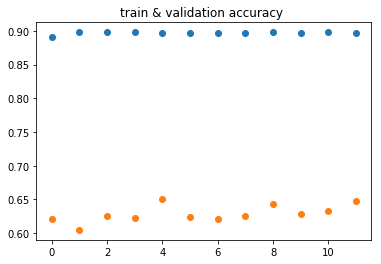

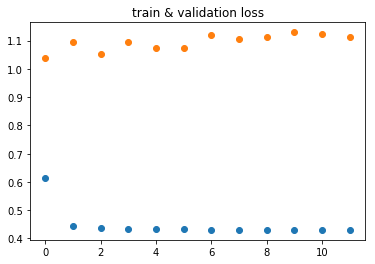

In [54]:
for cnn,i in zip([ cnn_0, cnn_1, cnn_2, cnn_3,cnn_4,cnn_5,cnn_6],range(7)):

    plt.plot(cnn.history.history['acc'], 'o')
    plt.plot(cnn.history.history['val_acc'],'o')
    plt.title("train & validation accuracy ")
    plt.legend()
    plt.savefig('fig_acc_'+str(i)+'.png')
    plt.show()


    plt.plot(cnn.history.history['loss'],'o')
    plt.plot(cnn.history.history['val_loss'],'o')
    plt.title("train & validation loss")
    plt.legend()
    plt.savefig('fig_loss_'+str(i)+'.png')
    plt.show()

In [27]:
[loss_value, accuracy] = cnn_0.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_1.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_2.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_3.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_4.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_5.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")
[loss_value, accuracy] = cnn_6.evaluate(Xts, Y_test)
print(f"Précision : {accuracy:0.2%}")

20000/20000 [==============================] - 8s 378us/step
Précision : 93.84%
20000/20000 [==============================] - 7s 373us/step
Précision : 94.93%
20000/20000 [==============================] - 8s 389us/step
Précision : 84.97%
20000/20000 [==============================] - 8s 390us/step
Précision : 84.76%
20000/20000 [==============================] - 8s 375us/step
Précision : 93.83%


In [39]:
# Pour ouvrir des modèles enregistrés

from keras.models import load_model
cnn_0=load_model("cnn_0.h5")

C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [41]:
cnn_0.evaluate(Xts, Y_test)

20000/20000 [==============================] - 11s 540us/step


[0.3132396464926834, 0.9521625]

In [44]:
cnn_1=load_model("cnn_1.h5")
cnn_1.evaluate(Xts, Y_test)

C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


20000/20000 [==============================] - 13s 665us/step


[0.1466130001506077, 0.959575]

In [47]:
cnn_2=load_model("cnn_2.h5")
cnn_2.evaluate(Xts, Y_test)

C:\Users\Mathieu\Anaconda3\envs\deeplearning\lib\site-packages\keras\engine\topology.py:1253: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


20000/20000 [==============================] - 10s 484us/step


[0.5553258490085602, 0.8492625]

In [55]:
#cnn_3=load_model("cnn_3.h5")
cnn_3.evaluate(Xts, Y_test)

20000/20000 [==============================] - 12s 586us/step


[0.5580807138442994, 0.8543]